In [ ]:
# Part A: Basic definitions and functions - we start by defining the basic constructs needed
# to interact with the Neo4j database. For Part A, we will establish a connection to a test
# database. Create some nodes and relationships and run some queries.

In [1]:
# There are at least 2 libraries for accessing Neo4j via Python. There is the official
# Neo4j driver provided by the company which can be installed using pip (Python package management)
# and via Anaconda for use with Jupyter: conda install -c conda-forge sqlalchemy neo4j-python-driver
# Currently using 
# See https://neo4j.com/developer/python/#python-driver
from neo4j import GraphDatabase
import requests # Fetch and preview data from API
import json # parse JSON
from itertools import permutations
import pandas as pd
from datetime import datetime as dt # Parse dates
import os
import time
import seaborn
import ipywidgets

In [2]:
#Incorporate in filename
def fnGetFilename(prefix, extension):
    sTS = dt.now().strftime("%m%d%Y_%H%M%S")
    return prefix + "_" + sTS + "." + extension

# Test function
fnGetFilename("api-data", "json")

'api-data_03182022_113604.json'

In [3]:
def fnGetFilepath(filename):
    # Path to the database file which on my machine is at /home/<user>/raw_data/.
    # Feel free to change.
    homeDir=os.getenv("HOME")
    filePath = os.path.join(homeDir, "raw_data", filename)
    return filePath

# Test function
fnGetFilepath(fnGetFilename("api-data", "json"))

'/home/automaton/raw_data/api-data_03182022_113606.json'

In [4]:
# Using a 3rd party library, ipywidgets, which has controls for common UI elements like the password field.
dbAuraNameWidget = ipywidgets.Text(value="", placeholder="", description="Aura DB Name:", disabled=False, 
                               style=dict(description_width='initial'))
display(dbAuraNameWidget)
dbAuraPasswordWidget = ipywidgets.Password(value="", placeholder="", description="DB Password:", disabled=False,
                                    style=dict(description_width='initial'))
display(dbAuraPasswordWidget)

Text(value='', description='Aura DB Name:', placeholder='', style=DescriptionStyle(description_width='initial'…

Password(description='DB Password:', placeholder='', style=DescriptionStyle(description_width='initial'))

In [6]:
# Establish a connection to Aura, Neo4j's fully managed database on the cloud. Keep in mind there are some 
# limitations on memory usage. So using Aura for the smaller demonstration with test data. Port 7687 is
# the default for Cypher.
if dbAuraNameWidget != None and dbAuraPasswordWidget != None:
    print("Connecting to: ", dbAuraNameWidget.value)
    conn = GraphDatabase.driver("neo4j+s://" + dbAuraNameWidget.value + ":7687", 
                                auth=("neo4j", dbAuraPasswordWidget.value))
else:
    print("Please run cell above and enter the database name and password above")

Connecting to:  303352be.databases.neo4j.io


In [7]:
# A simple function that creates a database query session and calls the user
# function to execute. This is using the transaction API which ensure
# atomicity and consistency which are technically not need for these simple examples. 
def fnUpdateQuery(conn, fnQuery, args={}):
    ret = None
    with conn.session() as session:
        ret = session.write_transaction(fnQuery, args)
    
    return ret

In [8]:
# Function that wraps read-only queries as transactions 
def fnReadQuery(conn, fnQuery, args={}):
    ret = None
    with conn.session() as session:
        ret = session.read_transaction(fnQuery, args)
    
    return ret

In [9]:
# Reset the database by dropping all the nodes
def fnResetDB(transaction, args):
    return transaction.run("MATCH(n) DETACH DELETE(n)")

In [10]:
# Return all the nodes
def fnGetAllNodes(transaction, args):
    result = transaction.run("MATCH(n) RETURN (n)")
    return [record["n"] for record in result]

In [11]:
# A simple function that create a node for each Person and assigns the first and last name.
# Also adding an auto-generated unique ID, in fact a UUID, to make it easier to query later.
def fnCreatePerson(transaction, args):
    result = transaction.run(
        "CREATE (a:Person {id: apoc.create.uuid(), firstName: $inFirstName, lastName: $inLastName}) RETURN a.id", 
        inFirstName=args["firstName"], inLastName=args["lastName"])
    
    return result.single()[0]

In [12]:
def fnGetIdFromName(transaction, args):
    result = transaction.run("MATCH(n:Person) WHERE n.firstName ='" + args["firstName"] + 
                                 "' AND n.lastName ='" + args["lastName"] + "' RETURN n.id AS id")
    return result.single()[0]

In [13]:
# Creating a generic association function that associates
# one person with one or more others
def fnAssociate(transaction, args):
    personId = args["personId"]
    association = args["association"]
    otherIds = args["otherIds"]
    
    # Create a one-way association by default from the person to the other
    for anotherId in otherIds:
        queryStr="""MATCH (a:Person), (b:Person) WHERE a.id = '{0}' AND b.id = '{1}'
                    CREATE (a)-[r:{2}]->(b);""".format(personId, anotherId, association)
        
        transaction.run(queryStr)
    
        
# This is an example of a one-way associations since the worker is not also the boss of the boss
def fnWorksFor(transaction, args):
    fnAssociate(transaction, {"personId": args["personId"], "association": "works_for",
                                     "otherIds": [args["bossId"]]})
    
    fnAssociate(transaction, {"personId": args["bossId"], "association": "employs",
                                     "otherIds": [args["personId"]]})
    
# This is an example of a two way since obviously a friend of A is also A's friend.    
def fnFriendsWith(transaction, args):
    fnAssociate(transaction, {"personId": args["personId"], "association": "friends_with",
                                 "otherIds": [args["friendId"]]})
    
    fnAssociate(transaction, {"personId": args["friendId"], "association": "friends_with",
                                 "otherIds": [args["personId"]]})

def fnSiblings(transaction, args):
    pairings = list(permutations(args["siblingIds"], 2))
    for pair in pairings:
        fnAssociate(transaction, {"personId": pair[0], "association": "sibling",
                                     "otherIds": [pair[1]]})

In [14]:
def fnDisassociate(transaction, args):
    query="MATCH (a:Person {id: '" + args["personId"] + "'})-[r: " + args["association"] + "]->(b:Person {id: '" + args["otherId"] + "'}) DELETE r"
    
    return transaction.run(query)
    
def fnUnfriend(transaction, args):
    fnDisassociate(transaction, {"personId": args["personId"], "association": "friends_with", 
                                 "otherId": args["friendId"]})
    
    fnDisassociate(transaction, {"personId": args["friendId"], "association": "friends_with", 
                                 "otherId": args["personId"]})

In [15]:
# Match all friends of the given person. Notice the arrow means we're
# returning those friends only once even though the relationship is bi-directional.
def fnGetFriends(transaction, args):
    query="MATCH (a:Person {id: '" + args["personId"] + "'})-[r:friends_with]->(b:Person) RETURN b"
    result = transaction.run(query)
    return [record["b"] for record in result]

# Rank function is not easily obtainable with an emphemeral / read-only query
# So let's do it as a to step function. Get the rank based on current counts.
def fnGetRankByNumFriends(transaction, args):
    query="""MATCH (a:Person)-[r1:friends_with]-(b:Person) 
                WITH a.firstName as fName, (count(b)/2) as fCount
                ORDER BY fCount DESC
                WITH COLLECT(DISTINCT {fCount:fCount}) as c
                unwind range(0, size(c)-1) as r
                return r as rank, c[r]["fCount"] as Friend_Count"""
    result = transaction.run(query)
    return [rank for rank in result]

def fnGetMostFriends(transaction, args):
    ranks = fnGetRankByNumFriends(transaction, args)
    query="""MATCH (a:Person)-[r1:friends_with]-(b:Person) 
                WITH a.firstName as fName, (count(b)/2) as fCount
                ORDER BY fCount DESC
                WHERE fCount={0} RETURN fName""".format(ranks[0]["Friend_Count"])
    result = transaction.run(query)
    return [record["fName"] for record in result]

def fnGetLeastFriends(transaction, args):
    ranks = fnGetRankByNumFriends(transaction, args)
    query="""MATCH (a:Person)-[r1:friends_with]-(b:Person) 
                WITH a.firstName as fName, (count(b)/2) as fCount
                ORDER BY fCount DESC
                WHERE fCount={0} RETURN fName""".format(ranks[-1]["Friend_Count"])
    result = transaction.run(query)
    return [record["fName"] for record in result]
    
def fnGetNoFriends(transaction, args):
    query="MATCH (a:Person) WHERE NOT (a)-[:friends_with]-() RETURN a.firstName"
    result = transaction.run(query)
    return [record["a.firstName"] for record in result]

In [16]:
# Assume id is unique and assigns it to exactly only
def fnSetAge(transaction, args):
    query = "MATCH (a:Person {id:'" + args["personId"] + "'})" + "SET a.age={0} RETURN a".format(args["age"])
    result = transaction.run(query)
    return result.single()[0]

# Let's find friends of friends and friends of siblings. Using union to combine all the relationships
# but because this can result in duplicates, especially due to two-way relationships let's explicit 
# filter out using DISTINCT
def fnRecommendFriends(transaction, args):
    query = "MATCH(a:Person {id:'" + args["personId"] + """'})-[r1:friends_with]-()-[r2:friends_with]-(ff1:Person)
               WHERE NOT EXISTS((a)-[r1:friends_with]-(ff1)) AND NOT EXISTS((a)-[r1:sibling]-(ff1))
               RETURN DISTINCT ff1 as ff
               UNION ALL MATCH(b:Person {id:'""" + args["personId"] + """'})-[r1:sibling]-()-[r2:friends_with]-(ff2:Person)
               WHERE NOT EXISTS((b)-[r1:friends_with]-(ff2)) AND NOT EXISTS((b)-[r1:sibling]-(ff2))
               RETURN DISTINCT ff2 as ff"""
    result = transaction.run(query)
    return [record["ff"] for record in result]

# Similar to the function above but we add some "qualifications" (i.e. age)
# Will return over 18 and those without an age. IS NULL and NOT EXISTS are equivalent
def fnRecommendWorkers(transaction, args):
    query = "MATCH(a:Person {id:'" + args["personId"] + """'})-[r1:employs]-(e1:Person)-[r2:friends_with]-(w1:Person)
               WHERE NOT w1.age IS NULL OR w1.age >= 18 
               RETURN DISTINCT w1 as w
               UNION ALL MATCH(b:Person {id:'""" + args["personId"] + """'})-[r1:employs]-(e2:Person)-[r2:sibling]-(w2:Person)
               WHERE NOT w2.age IS NULL OR w2.age >= 18
               RETURN DISTINCT w2 as w"""
    result = transaction.run(query)
    return [record["w"] for record in result]

In [17]:
# Simple utility function that converts a result set into a panda data frame
def fnGetFrameFromResultSet(result):
    return pd.DataFrame([dict(record) for record in result])

In [18]:
# In part A demonstrates basic Neo4j functions using some test data.
# Let's start with a clean slate by resetting the DB
fnUpdateQuery(conn, fnResetDB)

# Insert a couple of people
thomasId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "Thomas", "lastName": "McPherson"})
williamId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "William", "lastName": "Jones"})
marcusId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "Marcus", "lastName": "Jones"})
jammieId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "Jammie", "lastName": "Jones"})
harryId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "Harry", "lastName": "Carson"})
johnId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "John", "lastName": "Thompson"})
paulId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "Paul", "lastName": "Adams"})
karlId = fnUpdateQuery(conn, fnCreatePerson, {"firstName": "Karl", "lastName": "Thune"})

# Get people records from nodes
people = fnReadQuery(conn, fnGetAllNodes)

# Convert to data frame to make things easier
dfPeople = fnGetFrameFromResultSet(people)
print(dfPeople.head)

<bound method NDFrame.head of   firstName   lastName                                    id
0      Karl      Thune  80487da7-c354-4b69-927e-e545376304cd
1    Thomas  McPherson  dd9c7822-9b30-4bb6-8a71-4603c4804343
2   William      Jones  a547f444-a1df-44a7-863d-48256b34f4ea
3    Marcus      Jones  521710b1-ebb2-427f-9330-041fff2ce153
4    Jammie      Jones  d52b6356-cdb1-4f94-8b67-d9e56bccea97
5     Harry     Carson  eaaf8628-d827-4567-9c3c-7647825884fa
6      John   Thompson  229807f9-74e8-4d97-be22-d14ae93c3a43
7      Paul      Adams  ba110986-b05a-42a5-8b74-a23e5bec5d1d>


In [19]:
# Get the IDs from first and last name, in this case assumed to uniquely identify.
# Note we returned the IDs above on record creation.
thomasId = fnReadQuery(conn, fnGetIdFromName, {"firstName": "Thomas", "lastName": "McPherson"})
williamId = fnReadQuery(conn, fnGetIdFromName, {"firstName": "William", "lastName": "Jones"})

# Let's fetch the IDs by querying 
print("Thomas and William's Ids are %s, %s" % (thomasId, williamId))

# Now let's create some relationships. Since we created the IDs we can use those.
# Let's build some friendships
fnUpdateQuery(conn, fnFriendsWith, {"personId": thomasId, "friendId": williamId})
fnUpdateQuery(conn, fnFriendsWith, {"personId": thomasId, "friendId": jammieId})
fnUpdateQuery(conn, fnFriendsWith, {"personId": harryId, "friendId": thomasId})
fnUpdateQuery(conn, fnFriendsWith, {"personId": paulId, "friendId": harryId})
fnUpdateQuery(conn, fnFriendsWith, {"personId": karlId, "friendId": paulId})
fnUpdateQuery(conn, fnFriendsWith, {"personId": karlId, "friendId": harryId})

# And work relationships
fnUpdateQuery(conn, fnWorksFor, {"personId": jammieId, "bossId": johnId})

# And family
fnUpdateQuery(conn, fnSiblings, {"siblingIds": [williamId, marcusId, jammieId]})

Thomas and William's Ids are dd9c7822-9b30-4bb6-8a71-4603c4804343, a547f444-a1df-44a7-863d-48256b34f4ea


In [20]:
# And now let's do so basic queries that take advantage of graph database.
friends = fnReadQuery(conn, fnGetFriends, {"personId": harryId})
dfFriends = fnGetFrameFromResultSet(friends)
print("Harry's friends are ", ",".join(dfFriends["firstName"]))
print()

# Who has the most friends?
theMost = fnReadQuery(conn, fnGetMostFriends)
print("The most friends: ", theMost)

theLeast = fnReadQuery(conn, fnGetLeastFriends)
print("The least friends: ", theLeast)

Harry's friends are  Karl,Paul,Thomas

The most friends:  ['Thomas', 'Harry']
The least friends:  ['William', 'Jammie']


In [21]:
# Now let's break the connection - i.e. unfriend 
fnUpdateQuery(conn, fnUnfriend, {"personId": karlId, "friendId": harryId})

# And now who has the most friends?
theMost = fnReadQuery(conn, fnGetMostFriends)
print("And now, the most friends: ", theMost)

# No friends at all?
noFriends = fnReadQuery(conn, fnGetNoFriends)
print(noFriends, " have not friends at all.")
print()

# Recommend some friends for Marcus and Jammie?
newFriends = fnReadQuery(conn, fnRecommendFriends, {"personId": marcusId})
dfNewFriends = fnGetFrameFromResultSet(newFriends)
print("Suggest friends for Marcus:\n", dfNewFriends)
print()

newFriends = fnReadQuery(conn, fnRecommendFriends, {"personId": jammieId})
dfNewFriends = fnGetFrameFromResultSet(newFriends)
print("Suggest friends for Jammie:\n", dfNewFriends)

And now, the most friends:  ['Thomas']
['Marcus', 'John']  have not friends at all.

Suggest friends for Marcus:
   firstName   lastName                                    id
0    Thomas  McPherson  dd9c7822-9b30-4bb6-8a71-4603c4804343

Suggest friends for Jammie:
   firstName   lastName                                    id
0     Harry     Carson  eaaf8628-d827-4567-9c3c-7647825884fa
1    Jammie      Jones  d52b6356-cdb1-4f94-8b67-d9e56bccea97
2   William      Jones  a547f444-a1df-44a7-863d-48256b34f4ea
3    Thomas  McPherson  dd9c7822-9b30-4bb6-8a71-4603c4804343


In [22]:
# And let's enhance our people database with some additional information
# by setting the age. 
fnUpdateQuery(conn, fnSetAge, {"personId": jammieId, "age": 24})
fnUpdateQuery(conn, fnSetAge, {"personId": thomasId, "age": 29})
fnUpdateQuery(conn, fnSetAge, {"personId": williamId, "age": 25})
fnUpdateQuery(conn, fnSetAge, {"personId": harryId, "age": 26})
fnUpdateQuery(conn, fnSetAge, {"personId": marcusId, "age": 17})  

newWorkers = fnReadQuery(conn, fnRecommendWorkers, {"personId": johnId})
dfNewWorkers = fnGetFrameFromResultSet(newFriends)
print(dfNewWorkers)

  firstName   lastName                                    id
0     Harry     Carson  eaaf8628-d827-4567-9c3c-7647825884fa
1    Jammie      Jones  d52b6356-cdb1-4f94-8b67-d9e56bccea97
2   William      Jones  a547f444-a1df-44a7-863d-48256b34f4ea
3    Thomas  McPherson  dd9c7822-9b30-4bb6-8a71-4603c4804343


In [23]:
# Cleanup the connection
conn.close()

In [ ]:
# Part B: Now let's work with a more complex dataset. Neo4j has provided a sandbox environment which
# includes the dataset, cloud db, integrated graphical shell and walkthrough of the data model and queries.
# This can be found here: https://medium.com/neo4j/introducing-the-neo4j-stackoverflow-sandbox-69e3729d01f3

# For this part of the excercise, will be querying the data via REST, importing it into neo4j and basic review.

In [24]:
# Stack exchange APIs allows for the creation of custom filters to define which fields to return. The filter can be
# seen here: https://api.stackexchange.com/2.2/filters/!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf
def fnGetAPIFilter():
    return "!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf"

In [25]:
# Function to fetch 
def fnGetURL(keyword, page):
    return "https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&filter=" + fnGetAPIFilter() + "&site=stackoverflow&tagged=" + keyword + "&page=" + page

fnGetURL("neo4j", "13")

'https://api.stackexchange.com/2.2/questions?pagesize=100&order=desc&sort=creation&filter=!5-i6Zw8Y)4W7vpy91PMYsKM-k9yzEsSC1_Uxlf&site=stackoverflow&tagged=neo4j&page=13'

In [26]:
# We're using APOC is a plugin to inject JSON data into Neo4j. APOC is built into many Neo4j environments
# but there are some security restrictions especially with loading files. This works as follows:
#
# This is a fairly complicated query that is actually just a series of chained subqueries that extract tags
# and attribution for each question.
def fnInsertNeo4jQuestions(transaction, args):
    # To avoid issues with API, we store the file with all the records on AWS
    url = args["url"] #fnGetURL(args["keyword"], args["page"])

    # 1. Convert the list of objects in JSON into questions (top level object)
    # 2. Assign the title and link as property to each question node
    # 3. For each tag in question, get the tag and merge (assign to) the associated node
    # 4. Extract the answer as a separate node
    # 5. Extract the author of the question
    
    # Please note that there is bogus data like inconsistently encoded userID, NULL user IDs, numeric string.
    # Compensate for that in a simple way by looking for a NULL relationship.
    queryStr = "CALL apoc.load.json('" + url + """') YIELD value 
                UNWIND value.items AS q

                MERGE (question:Question {uuid:q.question_id})
                  ON CREATE SET question.title = q.title,
                    question.link = q.share_link,
                    question.creation_date = q.creation_date,
                    question.accepted_answer_id=q.accepted_answer_id,
                    question.view_count=q.view_count,
                    question.answer_count=q.answer_count,
                    question.body_markdown=q.body_markdown

                // who asked the question
                MERGE (owner:User {uuid:coalesce(q.owner.user_id,'deleted')})
                  ON CREATE SET owner.display_name = q.owner.display_name
                MERGE (owner)-[:ASKED]->(question)

                // what tags do the questions have
                FOREACH (tagName IN q.tags |
                  MERGE (tag:Tag {name:tagName})
                    ON CREATE SET tag.link = "https://stackoverflow.com/questions/tagged/" + tag.name
                  MERGE (question)-[:TAGGED]->(tag))

                // who answered the questions?
                FOREACH (a IN q.answers |
                   MERGE (question)<-[:ANSWERED]-(answer:Answer {uuid:a.answer_id})
                    ON CREATE SET answer.is_accepted = a.is_accepted,
                    answer.link=a.share_link,
                    answer.title=a.title,
                    answer.body_markdown=a.body_markdown,
                    answer.score=a.score,
                    answer.favorite_score=a.favorite_score,
                    answer.view_count=a.view_count
                   MERGE (answerer:User {uuid:coalesce(a.owner.user_id,'deleted')})
                    ON CREATE SET answerer.display_name = a.owner.display_name
                   MERGE (answer)<-[:PROVIDED]-(answerer)
                )

                // who commented on the question
                FOREACH (c in q.comments |
                  MERGE (question)<-[:COMMENTED_ON]-(comment:Comment {uuid:c.comment_id})
                    ON CREATE SET comment.link=c.link, comment.score=c.score
                  MERGE (commenter:User {uuid:coalesce(c.owner.user_id,'deleted')})
                    ON CREATE SET commenter.display_name = c.owner.display_name
                  MERGE (comment)<-[:COMMENTED]-(commenter)
                );
            """
    result = transaction.run(queryStr)

In [27]:
# Pull all questions and associated answers and comments for the keyword "neo4j".
keyword = "neo4j"

In [28]:
def fnFetchStackoverflowQA(saveFile, keyword, iPage):
    # Fetch all questions for this keyword. This is done via the helper function
    # which formats URL with the search term.
    print("Fetching and writing page %d" % iPage)
    url = fnGetURL(keyword, str(iPage))
    #print(url) 
    
    # Let's preview the JSON data representing the questions and answers
    response = requests.get(url)
    
    # Confirm 200 if data was successfully fetched
    print(response)
    
    # Convert response data to json
    qaData = json.loads(response.content.decode('utf-8'))
    
    # Items are the actual Questions with comments, answers
    if "items" in qaData:
        items = qaData["items"]

        # Sneak a peak (testing)
        #if iPage == 1:
        #    print(json.dumps(qaData["items"][0:1], indent=2))

        bFirst = iPage == 1
        # Append each object to file so we have a single list of items
        with open(pathToRawData, "a") as outfile:
            for item in items:
                if not bFirst:
                    outfile.write(",")
                bFirst = False
                json.dump(item, outfile)
            
        
    # API is paginated and returns results in pages of at most 100 records
    return "has_more" in qaData and qaData["has_more"] == True

In [29]:
# This will read the Q&A from the API and write to a file. Currently, it's writing to a 
# JSON file and that file is getting uploaded to S3 manually for use with APOC.

# Save the JSON data to avoid having to reload from API
pathToRawData = fnGetFilepath(fnGetFilename("stackoverflow-" + keyword, "json"))

# Parent object which will contain list of json
with open(pathToRawData, "w") as outfile:
    outfile.write('{"items":[')

iPage = 1

# Pages above 25 require auth token. So let's get as much as possible.
# Assume there is at least 1 page of results. List may have 0 records
# if the tag was not used.
hasMore = True
while hasMore and iPage <= 25:
    hasMore = fnFetchStackoverflowQA(pathToRawData, keyword, iPage)
    iPage = iPage + 1
    # Avoid API throttling (30 per second) by slowing down the requests
    time.sleep(4)
    
    url = fnGetURL(keyword, str(iPage))
        
    response = requests.get(url)

# "Close" parent object
with open(pathToRawData, "a") as outfile:
    outfile.write(']}')

Fetching and writing page 1
<Response [200]>
Fetching and writing page 2
<Response [200]>
Fetching and writing page 3
<Response [200]>
Fetching and writing page 4
<Response [200]>
Fetching and writing page 5
<Response [200]>
Fetching and writing page 6
<Response [200]>
Fetching and writing page 7
<Response [200]>
Fetching and writing page 8
<Response [200]>
Fetching and writing page 9
<Response [200]>
Fetching and writing page 10
<Response [200]>
Fetching and writing page 11
<Response [200]>
Fetching and writing page 12
<Response [200]>
Fetching and writing page 13
<Response [200]>
Fetching and writing page 14
<Response [200]>
Fetching and writing page 15
<Response [200]>
Fetching and writing page 16
<Response [200]>
Fetching and writing page 17
<Response [200]>
Fetching and writing page 18
<Response [200]>
Fetching and writing page 19
<Response [200]>
Fetching and writing page 20
<Response [200]>
Fetching and writing page 21
<Response [200]>
Fetching and writing page 22
<Response [200

In [30]:
# As mentioned earlier, the free Aura DBs had some strict memory limitations (250 MB). 
# So we're using a self-hosted Neo4j DB for the larger Q&A dataset.
dbHomeNameWidget = ipywidgets.Text(value="", placeholder="", description="Home DB Name:", disabled=False, 
                               style=dict(description_width='initial'))
display(dbHomeNameWidget)
dbHomePasswordWidget = ipywidgets.Password(value="", placeholder="", description="DB Password:", disabled=False,
                                    style=dict(description_width='initial'))
display(dbHomePasswordWidget)



Text(value='', description='Home DB Name:', placeholder='', style=DescriptionStyle(description_width='initial'…

Password(description='DB Password:', placeholder='', style=DescriptionStyle(description_width='initial'))

In [31]:
if dbHomeNameWidget != None and dbHomePasswordWidget != None:
    print("Connecting to: ", dbHomeNameWidget.value)
    connHome = GraphDatabase.driver("neo4j://" + dbHomeNameWidget.value + ":7687", 
                                auth=("neo4j", dbHomePasswordWidget.value))
else:
    print("Please run cell above and enter the database name and password above")

Connecting to:  paris.local


In [32]:
# Initialize the database by flush all the records
fnUpdateQuery(connHome, fnResetDB)

# JSON file was created from the function above which fetches data from Stackoverflow APIs and uploaded to a public
# S3 bucket.
url = "http://s3.msds.rutgers.org.s3-website-us-east-1.amazonaws.com/special_topics/stackoverflow-neo4j_03152022_121720.json"
fnUpdateQuery(connHome, fnInsertNeo4jQuestions, {"url": url})


In [33]:
# Start with some basic statics. To simplify the code code the query inline using Lambda function.
# Get the # of users, questions, answers and tags (categories)
result = fnReadQuery(connHome, lambda transaction, args : 
                     transaction.run("MATCH(n:User) RETURN count(n)").single()[0])
print("Number of users: ", result)

result = fnReadQuery(connHome, lambda transaction, args : 
                     transaction.run("MATCH(n:Question) RETURN count(n)").single()[0])
print("Number of questions: ", result)

result = fnReadQuery(connHome, lambda transaction, args : 
                     transaction.run("MATCH(n:Answer) RETURN count(n)").single()[0])
print("Number of answers: ", result)

result = fnReadQuery(connHome, lambda transaction, args : 
                     transaction.run("MATCH(n:Comment) RETURN count(n)").single()[0])
print("Number of comments: ", result)
print()

# And a simpler way to get all the node-tags
dfNodes = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("MATCH(n) RETURN labels(n) as label, count(*)")))
                     
print("Number of nodes: ", dfNodes)

Number of users:  2108
Number of questions:  2494
Number of answers:  2260
Number of comments:  2362

Number of nodes:          label  count(*)
0      [User]      2108
1    [Answer]      2260
2   [Comment]      2362
3  [Question]      2494
4       [Tag]       671


In [34]:
# Now let's see what are the 20 most popular tags for Neo4j
dfTagCounts = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH(n:Question)-[r:TAGGED]-(t:Tag) 
                                             RETURN t.name, count(*) as tagCount
                                             ORDER BY tagCount DESC LIMIT 20""")
                     ))
                     
print(dfTagCounts)

                t.name  tagCount
0                neo4j      2494
1               cypher      1122
2           neo4j-apoc       206
3      graph-databases       164
4               python       146
5                 java       139
6    spring-data-neo4j       109
7                graph       107
8              graphql        79
9             database        76
10         spring-boot        75
11              py2neo        69
12             node.js        63
13          javascript        55
14              docker        52
15              spring        49
16                 csv        40
17                json        33
18  graph-data-science        32
19                  c#        32


In [35]:
# And who are the top users who asked the most questions
dfQCounts = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH(u:User)-[r:ASKED]-(q:Question) 
                                             RETURN u.display_name, count(*) as qCount
                                             ORDER BY qCount DESC LIMIT 10""")
                     ))
print(dfQCounts)

  u.display_name  qCount
0           LJRB      20
1    Thingamajig      15
2           A. L      13
3   Aerodynamika      12
4          Ooker      12
5         marlon      11
6   user11333043      11
7  Armen Sanoyan      11
8           Sama      11
9       David542      10


,name,ansCount,avgScore
0,cybersam,257,0.564202
1,Graphileon,206,0.616505
2,Tomaž Bratanič,202,0.599010
3,jose_bacoy,165,0.496970
4,InverseFalcon,95,0.536842
5,Christophe Willemsen,66,0.818182
6,fbiville,49,0.632653
7,David A Stumpf,36,0.305556
8,meistermeier,32,0.687500
9,Luanne,29,0.793103


<AxesSubplot:xlabel='ansCount', ylabel='avgScore'>

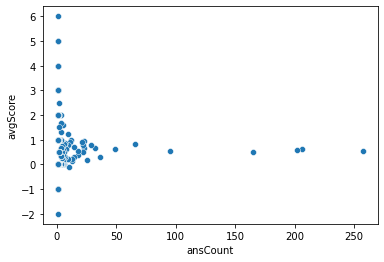

In [36]:
# And who answered the most questions and how they scored (based on average of votes)
dfAnswer = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH(u:User)-[r:PROVIDED]-(a:Answer)-[:ANSWERED]->(q:Question) 
                                             RETURN u.display_name as name, count(a) as ansCount, avg(a.score) as avgScore
                                             ORDER BY ansCount DESC, avgScore""")
                     ))
display(dfAnswer.head(10))

# Let's see the distribution of
seaborn.scatterplot(data=dfAnswer, x="ansCount", y="avgScore")


In [37]:
# Who would be best to ask about Neo4j or where confidence is high that the answer is correct?
# Who scored well? Defined as avg >= 1 and answered at least 5 questions
dfAnsweredWell = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH(u:User)-[r:PROVIDED]-(a:Answer)-[:ANSWERED]->(q:Question) 
                                             WITH u.display_name as name, count(a) as ansCount, avg(a.score) as avgScore
                                             WHERE ansCount > 5 and avgScore > .9
                                             RETURN name, ansCount, avgScore
                                             ORDER BY ansCount DESC, avgScore ASC""")
                     ))
dfAnsweredWell.head(10)

,name,ansCount,avgScore
0,Michael Hunger,23,0.956522
1,Nigel Small,21,0.904762
2,stellasia,12,1.000000
3,H&#229;kan L&#246;fqvist,11,0.909091
4,Mafor,9,1.222222


In [38]:
# Who scored poorly and maybe should be ignored? Defined as avg < .5 and answered at least 5 questions
dfAnsweredPoorly = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH(u:User)-[r:PROVIDED]-(a:Answer)-[:ANSWERED]->(q:Question) 
                                             WITH u.display_name as name, count(a) as ansCount, avg(a.score) as avgScore
                                             WHERE ansCount > 5 and avgScore < .25
                                             RETURN name, ansCount, avgScore
                                             ORDER BY ansCount DESC, avgScore ASC""")
                     ))
dfAnsweredPoorly.head(10)

,name,ansCount,avgScore
0,plastic,25,0.200000
1,norihide.shimatani,13,0.153846
2,hoyski,13,0.230769
3,Adrian Keister,10,-0.100000
4,manonthemat,9,0.222222
5,A. L,9,0.222222
6,Lukasmp3,9,0.222222
7,Michael Porter,6,0.000000


In [39]:
# Is there a pattern where certain users questions are answered by the same person?  
dfBuddies = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH (u:User)-[PROVIDED]->()-[a:ANSWERED]-()-[:ASKED]-(u2:User)
                                            WHERE NOT u.display_name = u2.display_name
                                            RETURN u.display_name as responder, u2.display_name as questioner,
                                                count(*) as pairCount
                                            ORDER BY pairCount desc LIMIT 10;""")
                     ))
dfBuddies.head(10)

,responder,questioner,pairCount
0,cybersam,LJRB,7
1,Graphileon,A. L,5
2,Tomaž Bratanič,LJRB,5
3,cybersam,Sean,4
4,Tomaž Bratanič,SteveS,4
5,Graphileon,Ooker,4
6,cybersam,ck22,4
7,Charlotte Skardon,Prateek,4
8,Tomaž Bratanič,user2167741,3
9,Graphileon,crazyfrog,3


In [40]:
# Questions that were answered quickly and by whom
dfUnanswered = fnReadQuery(connHome, lambda transaction, args : 
                     fnGetFrameFromResultSet(
                         transaction.run("""MATCH (q:Question)-[:TAGGED]->(t:Tag)
                                             WHERE NOT t.name in ['""" + keyword + """']
                                                 AND NOT (q)<-[:ANSWERED]-()
                                             RETURN t.name as tag, count(q) as unansweredCount
                                             ORDER BY unansweredCount DESC LIMIT 10""")
                     ))
dfUnanswered.head(10)

,tag,unansweredCount
0,cypher,174
1,java,55
2,neo4j-apoc,52
3,python,36
4,spring-data-neo4j,35
5,spring-boot,34
6,graphql,27
7,graph-databases,26
8,graph,20
9,spring,19


In [ ]:
# Cleanup connection
connHome.close()